# Numba-accelerated Jackknife

My [resample](https://scikit-hep.org/resample/) library implements the jackknife and bootstrap resampling techniques. The implementations use pure-Python. Since resampling techniques are computationally expensive, it is important to ask whether we can speed up these methods with Numba. In this notebook I compare a JIT-compiled implementation of the Jackknife with the pure Python implementation from `resample`.

Since Numba currently does not support JIT-compiled functions which accept other functions as arguments, the JIT-compiled version has to work a little differently from the pure-Python version. It creates a two-dimensional array with all leave-one-out samples at once inside the compiled code. This array is then passed to Python and the function is evaluated over this array. This has a downside: For large samples, creating an N x (N-1) array in memory becomes dangerous since the memory allocation may bring the computer down and very slow.

Fortunately, it turns out that there is nothing to gain from JIT-compiling and thus there is no need to accept this caveat.

In [20]:
from resample.jackknife import jackknife
import numpy as np
import numba as nb
from typing import Callable
from timeit import timeit
from matplotlib import pyplot as plt

In [21]:
@nb.njit(nogil=True)
def _jackknife_jit(a: np.ndarray):
    n = len(a)
    x = np.empty((n, n - 1), dtype=a.dtype)
    for i in range(n):
        for j in range(n-1):
            shift = 0 if j < i else 1
            x[i, j] = a[j + shift]
    return x


@nb.njit
def _jackknife_gen(a):
    n = len(a)
    x = np.empty(n - 1, a.dtype)
    for i in range(n - 1):
        x[i] = a[i + 1]
    yield x.view(x.dtype)

    # update needs to change values only up to i
    # for a = [0, 1, 2, 3]
    # x0 = [1, 2, 3]
    # x1 = [0, 2, 3]
    # x2 = [0, 1, 3]
    # x3 = [0, 1, 2]
    for i in range(1, n):
        for j in range(i):
            x[j] = a[j]
        yield x.view(x.dtype)


def jackknife_jit(fn: Callable, a: np.ndarray) -> np.ndarray:
    return np.asarray([fn(x) for x in _jackknife_gen(a)])

# force compilation
jackknife_jit(np.mean, np.random.randn(10));

In [22]:
x = np.random.rand(10000)

In [23]:
%%timeit
jackknife(np.mean, x)

105 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%%timeit
jackknife_jit( np.mean, x)

119 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The results are comparable. This also remains so when we benchmark samples of varying size.

In [25]:
n = np.asarray(np.geomspace(3, 20000, 50), dtype=int)
times = {
    ("jackknife", "np.mean"): np.empty(len(n)),
    ("jackknife_jit", "np.mean"): np.empty(len(n)),
}
for i, ni in enumerate(n):
    x = np.random.randn(ni)
    for s_fcn, s_arg in times:
        t = timeit(f"{s_fcn}({s_arg}, x)", f"from __main__ import {s_fcn}, x; import numpy as np", number=1)
        times[(s_fcn, s_arg)][i] = t

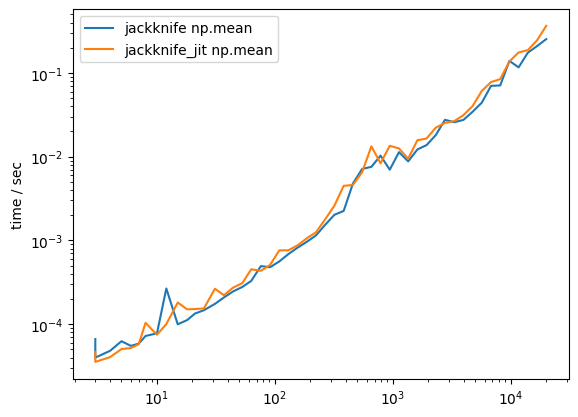

In [26]:
plt.figure()
for (s_fcn, s_arg), ts in times.items():
    plt.plot(n, ts, label=f"{s_fcn} {s_arg}")
plt.loglog()
plt.ylabel("time / sec")
plt.legend();